# PBR Exp 1-4 Data & Model Application

    Here I load and process the Photo Bioreactor (PBR) data. I first segregate the absorbance data from the 'pumped-in-media' data. The latter reflects the growth of the system---as cells grow more light is blocked thus prompting the sytem to flush and dilute the system with fresh media.
    
    The main components of the data are the absorbance signal at A680 and A720, the pumped-in data (TBD mL), the path-length of the growth vessels (2.7cm) and their volumes (TBD mL). The system takes many and variable measurements per hour and thus should be averaged when extracting specific date-times.
    
    Two types of models can be applied to this data: the singular straing calibration models and the newer SynCom calibration models. There exists simple linear regression and multiple-linear regression models that determine the fraction of each component bacteria [B] or chlamydomonas [C], but these have been made with the data measured with a Tecan. Since the models are created using Tecan measured data, these have to be adapted to the PBR data by adjust coefficients to the path-length of the PBR growth vessels. 

Note:
    
    Now with the SynComm calibration data and cell counts data, we can use the Tecan-measured Exp2 & 3 data's datetime information and pull the average of these respective PBR data. Use a scatterplot to to check how those measurements compare against one another. 

In [1]:
# For each experiement you have to cut data in to epochs
# For each epoch you have to combine the daily sample measurements
    # Exp_X:
        # pbr vessel measuremnet average over that span of time
        # growth rate at that time using the 
        # tecan measurement of that sample
        # cell counter measurement for that sample
        # 

# Imports

In [2]:
import numpy as np
import pandas as pd
import os
import scipy

from sklearn import preprocessing

import matplotlib.pyplot as plt
#%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
#sns.set(style='whitegrid')

import itertools as it

from os.path import join as pjoin

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Helper Functions

In [3]:
def extract_pbr_timeseries(df, extract_time, time_delta='30min', return_single=False):
    """
    This function returns a time specific portion of the PBR DataFrame consisting
    of the previous 16min (as default) of the input extract_time and the post 5min.
    If return_single=True, a resampled mean of that portion is returned as single 
    row DF
    """
    
    # ensure that the arguments are in the proper format for manipulation
    st = pd.to_datetime(extract_time)    
    td = pd.to_timedelta(time_delta)
    m6 = pd.to_timedelta('5min')
    
    # create mask from relevant dates
    mask = (df.index > st-td) & (df.index <= st+m6)
    
    # extracted dates DF
    ext =  df.loc[mask]
    
    if not return_single:
        
        return ext.dropna(how='any')
    
    else:
        # down sample the extracted dates to 5min buckets and return the row
        # that is closest in time with the requested 'extract_time' parameter
        ext = ext.resample(m6, label='left').mean().dropna(how='any')
        print('ext', ext)
        # index of 'nearest' to requested time
        idx = ext.index.get_loc(st, method='nearest')#get index date
        print('idx', idx)
        # Series needs to be transformed for posterity
        single_row = pd.DataFrame(ext.iloc[idx]).T
        
        return single_row
        

def extract_pbr_timeseries_row(df, extract_time):
    """
    This function returns a time specific portion of the PBR DataFrame consisting
    of the previous 16min (as default) of the input extract_time and the post 5min.
    If return_single=True, a resampled mean of that portion is returned as single 
    row DF
    """
    
    # ensure that the arguments are in the proper format for manipulation
    st = pd.to_datetime(extract_time)    
   
    # down sample the extracted dates to 5min buckets and return the row
    # that is closest in time with the requested 'extract_time' parameter
    #ext = df.resample(time_delta, label='left').mean().dropna(how='any')
    # index of 'nearest' to requested time
    idx = df.index.get_loc(st, method='nearest')#get index date
    # Series needs to be transformed for posterity
    single_row = pd.DataFrame(df.iloc[idx]).T

    return single_row

In [4]:
def return_resampled_df(tsdf, rtime='20 min', clean=False):
    """This function quickly returns a resampled dataframe which can be
    subsequently analyzed. The dataframe's index should be of datetime type. 
    
    Note: Often when these dataframes are resampled they tend to be returned
    with many missing values (NaN). This is because the data that was at variable
    times creating some gaps for which data cannot be aggregated.
    """
    df = tsdf.copy()
    
    # convert rtime into timedelta datatype
    rtime = pd.Timedelta(rtime)
    
    df = df.resample(rtime).mean()
    
    if clean:
        for i in range(len(dfs)):
            df = df.dropna(how='any')
        
    return df

In [5]:
# extract regressor Coefficients
def get_regr_coefficients(coeff_df, wavelength='560', and_mlr_model=False):
    
    """This function extracts the Tecan data regression coefficients and returns
    them as an array. The simple regresssion coefficient are modified for 
    application to the PBR pathlength. """
    
    if and_mlr_model==False:
        ks = coeff_df.loc[wavelength].values[:4] #* 2.7
        
    # include machine learning model coefficients    
    elif and_mlr_model:
        ks1 = coeff_df.loc[wavelength].values[:4] * 2.7
        
        # mlr models are divided by the pathlength--this has to do with the
        # way the predicted values are calculated, its an algebraic manipulation
        ks2 = coeff_df.loc[wavelength].values[4:] / 2.7
        ks = np.append(ks1, ks2)
    
    return ks
    
    

def apply_model(pbr_data, k, and_mlr_model=False):
    """This function applies the models to the PBR data and returns the complete dataframe
    and calcuated values.# IFF the model hold true, then the values obtained here should match
    those that are obtained at the the Tecan reader. At the very least the ratios should match.
    """
    
    tdf = pbr_data.copy()    
    get_params = zip(*[iter(tdf.columns)]*2)
    
    if and_mlr_model ==False:

        flag=0
        while flag < 8:

            # stop operation after the 8th pair of vessel values
            A680, A720 = next(get_params)

            # vessel number
            V = A680[-1]


            
            tdf['Bv%s' %V] = (tdf[A680]*k[3] - tdf[A720]*k[1]) / (k[3]*k[0] - k[1]*k[2])
            tdf['Cv%s' %V] = (tdf[A680]*k[2] - tdf[A720]*k[0]) / (k[2]*k[1] - k[0]*k[3])  
            
            
            #tdf['Bv%s' %V] = (Ks[1]*tdf[A720] - Ks[3]*tdf[A680]) / (Ks[1]*Ks[2] - Ks[3]*Ks[0])
            #tdf['Cv%s' %V] = (Ks[0]*tdf[A720] - Ks[2]*tdf[A680]) / (Ks[0]*Ks[3] - Ks[2]*Ks[1])
            tdf['SSv%s' %V] = tdf['Bv%s' %V] + tdf['Cv%s' %V]
            
            # predicted fraction
            #tdf['Bf_v%s' %V] =  tdf['Bv%s' %V] / tdf['SSv%s' %V]
            #tdf['Cf_v%s' %V] =   tdf['Cv%s' %V] / tdf['SSv%s' %V]
            
            # ratio is not very informative
            tdf['B/C_v%s' %V] = tdf['Bv%s' %V] / tdf['Cv%s' %V]

            flag+=1
    
    elif and_mlr_model:
        
        flag=0
        while flag < 8:

            # stop operation after the 8th pair of vessel values
            A680, A720 = next(get_params)

            # vessel number
            V = A680[-1]
            
            # simple regression
            tdf['Bv%s' %V] = (Ks[1]*tdf[A720] - Ks[3]*tdf[A680]) / (Ks[1]*Ks[2] - Ks[3]*Ks[0])
            tdf['Cv%s' %V] = (Ks[0]*tdf[A720] - Ks[2]*tdf[A680]) / (Ks[0]*Ks[3] - Ks[2]*Ks[1])
            
            
            
            
            
            tdf['SSv%s' %V] = tdf['Bv%s' %V] + tdf['Cv%s' %V]
            tdf['B/C_v%s' %V] = tdf['Bv%s' %V] / tdf['Cv%s' %V]
            
            # multiple linear regresssion
            tdf['B_mlr_v%s' %V] = Ks[4]*tdf[A680]+Ks[5]*tdf[A720]
            tdf['C_mlr_v%s' %V] =  Ks[6]*tdf[A680]+Ks[7]*tdf[A720]
            tdf['SS_mlr_v%s' %V] = tdf['B_mlr_v%s' %V] + tdf['C_mlr_v%s' %V]
            
            # the ratio of signals is not very informative
            #tdf['B/C_mlr_v%s' %V] = tdf['B_mlr_v%s' %V] / tdf['C_mlr_v%s' %V]
            
            # instead use fraction of total predicted signal
            tdf['Bf_v%s' %V] =  tdf['Bv%s' %V] / tdf['SSv%s' %V]
            tdf['Cf_v%s' %V] =   tdf['Cv%s' %V] / tdf['SSv%s' %V]
            tdf['Bf_mlr_v%s' %V] = tdf['B_mlr_v%s' %V] / tdf['SS_mlr_v%s' %V]
            tdf['Cf_mlr_v%s' %V] = tdf['C_mlr_v%s' %V] / tdf['SS_mlr_v%s' %V]
            
            # calculate the root-squared differences between the two types of predictions
            tdf['Bdif_v%s' %V] =  np.sqrt(np.power(tdf['B_mlr_v%s' %V] - tdf['Bv%s' %V], 2))
            tdf['Cdif_v%s' %V] =  np.sqrt(np.power(tdf['C_mlr_v%s' %V] - tdf['Cv%s' %V], 2))
            

            flag+=1
        
    return tdf
        


In [6]:
param_path = '../data_o/calibration/community_calibration/created_models/reqd_corr_funcs_parameters.csv'

def get_corr_params(file_loc, model='A680_A750_560'):
    
    print(model)
    
    df = pd.read_csv(file_loc, index_col=0, engine='python')
    
    return df.loc[model].values

def  corr_func_Bsc(pB, pC, parameters, which_a2=None):
    """Correction function"""
    # There are 3 options about which a2 to use,
    # a2 refers to the breadth of the correcting
    # parabola. These are either the:
        # mean
        # median
        # a2 @ [B]= 0 (Row12)
    
    
    a2s = parameters[:-2]
    hfit = parameters[-2:]
    # WHICH Parabolic BREADTH to use for correction
    if which_a2 =='mean':
        a2 = np.mean(a2s) # this is the mean
        
    elif which_a2 =='median':
        a2 = np.median(a2s) # this should be more robust to outliers
    
    # set as default
    else:
        a2 = -0.499525586 #global over 3 models... also this has the effect
        # of 'canceling out' the need for 'b' as 

    # given the fitted line avove, use poly1d to create a 
    # prediction function
    htor = np.poly1d(hfit)
    
    # takes in the predicted pB and spits out h in (h, k) the parabola
    # that lives at this pB... i.e. vertex is at (h,pB)
    lH = htor(pB)
    
    
    # IMPORTANT #
    # this is from an algebraic manipulation of the parabolic function
    # in polynomial and parabolic form where h = -b/2*a2 --- since we
    # "know: a2 and p_h is dependant on the concetration of B we 
    # estimate the likely value of b in f(x) = a2*x^2 + b*x + c
    b = np.multiply(-2*lH,a2 )    
    cv_tor = np.poly1d([a2, b, 0])
    
    return cv_tor(pC)

In [7]:
def visualize_pbr_predictions(df, tube_list='all', x_range= 'all', sig_ra=False, corr='Corrected'):
    
    """Figure out how to add ax to figure"""
    
    
    if tube_list == 'all':
        tube_list = [1, 2, 3, 4, 5, 6, 7, 8]
        
    if x_range == 'all':
        
        x_range = [df.index[0], df.index[-1]]
    
    for V in tube_list:
        fig, ax = plt.subplots(figsize=(9, 5))
        
        
                
        if sig_ra:
            ax2 = ax.twinx()
            
            df.loc[x_range[0]:x_range[1], 'Bra%s' %V].plot(ax=ax, color='tomato',legend=True, )
            df.loc[x_range[0]:x_range[1], 'Cra%s' %V].plot(ax=ax2, color='mediumseagreen', legend=True, )

            ax.legend(loc='upper left')
            ax2.legend(loc='upper right')

            ax.grid(b=True, axis='both')
            ax.set_ylabel('Signal RA of A$_{560}$ Predictions')

            plt.tight_layout()        
            fig.suptitle(corr, y=1.01)
            
        else:
            # plot concentrations
            df.loc[x_range[0]:x_range[1], 'Bv%s' %V].plot(ax=ax, color='tomato',legend=True, )
            df.loc[x_range[0]:x_range[1], 'Cv%s' %V].plot(ax=ax, color='mediumseagreen', legend=True, )
            #df.loc[x_range[0]:x_range[1], 'SSv%s' %V].plot(ax=ax, color='purple', legend=True)
            
        ax.legend(loc='upper left')
        #ax2.legend(loc='upper right')
        
        ax.grid(b=True, axis='both')
        ax.set_ylabel('Predicted A$_{560}$ Concentration')
        #ax.set_yticks(np.arange(-0.05, 1, .2))
        plt.tight_layout()        
        fig.suptitle(corr, y=1.01)
        

In [8]:
def raw_data_visualizer(df, raw=True):
    """Use this to visualises the entirity of the the tubes raw data,
    don't use it for the predictions"""
    fig, ax = plt.subplots(figsize=(10,5))
    
    
    if raw:

        df.plot(ax=ax,legend=True)
        ax.legend(prop={'size':6}, title='Measurements')

        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        #ax.set_xticks()
        #ax.set_yticks(np.arange(-0.05, 1, .2))
        ax.grid(b=True, axis='both')
        ax.set_ylabel('Empirical Absorbance')
        
    elif not raw:
        df[[i for i in df.columns if 'v' in i]].plot(ax=ax, legend=True)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()
    
def mlr_slr_compare(df):
    """The MLR models and SLR models achieve the same answers """
    pred_columns= pbr_modeled_560[0].columns.unique().values[16:]
    slr_cols = [i for i in pred_columns if 'mlr' not in i and '/' not in i]
    mlr_cols = [i for i in pred_columns if 'mlr' in i and '/' not in i]
    
    for i in range(len(slr_cols)):
        fig, ax = plt.subplots(figsize=(9,5))
        df[[slr_cols[i], mlr_cols[i]]].plot(ax=ax)
        plt.show()

def show_difs(df):
    # show the difference between MLR and SLR predictions
    
    pred_columns= pbr_modeled_560[0].columns.unique().values[16:]

    B = [i for i in pred_columns if 'Bdif' in i]
    C = [i for i in pred_columns if 'Cdif' in i]
    
    for i in range(len(B)):
        fig, ax = plt.subplots(figsize=(9,5))
        df[[B[i], C[i]]].plot(ax=ax)
        plt.show()

In [9]:
def visualize_pbr_CC_predictions(df, tube_list='all', x_range= 'all', ratio=False, ra=False, corr='Corrected'):
    
    """Figure out how to add ax to figure"""
    
    
    if tube_list == 'all':
        tube_list = [1, 2, 3, 4, 5, 6, 7, 8]
        
    if x_range == 'all':
        
        x_range = [df.index[0], df.index[-1]]
    
    for V in tube_list:
        fig, ax = plt.subplots(figsize=(9, 5))
        
        
        if ratio:
            
            df.loc[x_range[0]:x_range[1], 'B/Cc%s' %V].plot(ax=ax)
            ax.set_ylabel('B:C Ratio of A$_{560}$ Predictions')
            
            
            ax.legend(loc='upper left')
            fig.suptitle(corr, y=1.01)
            
        
        elif ra:
            ax2 = ax.twinx()
            
            df.loc[x_range[0]:x_range[1], 'Bpra%s' %V].plot(ax=ax, color='tomato',legend=True, )
            df.loc[x_range[0]:x_range[1], 'Cpra%s' %V].plot(ax=ax2, color='mediumseagreen', legend=True, )

            ax.legend(loc='upper left')
            ax2.legend(loc='upper right')

            ax.grid(b=True, axis='both')
            ax.set_ylabel('Cell-Counts RA of A$_{560}$ Predictions')

            plt.tight_layout()        
            fig.suptitle(corr, y=1.01)
        

        
        else:
            # plot concentrations
            ax2 = ax.twinx()
            df.loc[x_range[0]:x_range[1], 'Bv%s' %V].plot(ax=ax, color='tomato',legend=True, )
            df.loc[x_range[0]:x_range[1], 'Cv%s' %V].plot(ax=ax2, color='mediumseagreen', legend=True, )
            
            
            
            ax.set_ylim((0, 200e6))
            ax2.set_ylim((0, 10e6))
            ax.grid(b=True, axis='both')
            
            ax.set_ylabel('Cell-Counts of A$_{560}$ Predictions')
        
            ax.legend(loc='upper left')
            ax2.legend(loc='upper right')
        #x.grid(b=True, axis='both')        
        
        plt.tight_layout()        
        fig.suptitle(corr, y=1.01)

In [10]:
def  pred_to_cell_counts(pVal, parameters, B_or_C='B'):
    """To Cell Counts"""

    
    
    kB, kC = parameters.iloc[0].values
    Btor = np.poly1d([kB,0])
    Ctor = np.poly1d([kC,0])
    # takes in the predicted pB and spits out h in (h, k) the parabola
    # that lives at this pB... i.e. vertex is at (h,pB)
    
    if B_or_C == 'B':
        return Btor(pVal)
        
    if B_or_C == 'C':
        return Ctor(pVal)

# Data

In [11]:
pbr_path = '../data_o/pbr/'

locs = []
for root, dirs, files in os.walk(pbr_path):
    for name in files:
        if 'MC_data' in name:
            locs.append(os.path.join(root, name))
#locs

# Pre-processing

In [12]:
pbr1 = pd.read_csv(locs[1], sep='\t', skiprows=20, dtype=float)
pbr2 = pd.read_csv(locs[0], sep='\t', skiprows=20, dtype=float, na_values='n')
pbr3 = pd.read_csv(locs[4], sep='\t', skiprows=19, dtype=float)
pbr4a = pd.read_csv(locs[3], sep='\t', skiprows=19, dtype=float)
pbr4b = pd.read_csv(locs[2], sep='\t', skiprows=19, dtype=float)

### Get Start Times
    
    Start times for each pbr experiment were manually obtained from the raw dataset
    they're in order of conducted experiment

In [13]:
# start time of each experiment as stamped on the raw dataset
sts = ['2019-02-25 20:04:49',
       '2019-04-17 21:15:43',
       '2019-05-11 18:20:50',
       '2019-07-01 21:22:36',
       '2019-07-10 12:42:08']

In [14]:
# store dataframes in list
dfs = [pbr1, pbr2, pbr3, pbr4a, pbr4b ]

# relevant columns
keep_cols = dfs[0].columns[:17]

# pump data is found after OD columns (index=16)
pump_dfs = []
for i in range(len(dfs)):
    # change time to timedelta
    
    dfs[i]['time'] = pd.Timestamp(sts[i]) + pd.to_timedelta(dfs[i]['time'], unit='H').dt.floor('min')
    #dfs[i]['time']
    
    # append to pumpdata
    pump_dfs.append(dfs[i].iloc[:,17:])
    # remove pump data from dfs stored array
    dfs[i] = dfs[i][keep_cols].set_index(keys='time', drop=True)
    dfs[i] = dfs[i].dropna(how='any')


# create dictionary to remap column names
renamed = {}
for col in dfs[0].columns.values:
    v, wav = col.strip('od-sensors')[0], col.strip('od-sensors')[5:8] 
    renamed[col] = 'A'+wav+'_V'+v


# rename columns
for i in range(len(dfs)):
    dfs[i] = dfs[i].rename(mapper=renamed, axis=1)

# concatenate pbr4 parts and drop latter portio from dfs
dfs[3] = dfs[3].append(dfs[4])
dfs = dfs[:4]

    # PBR data does not have blank measurements, however only the PBR4 seems to be 
    # unplaugued by experiemental errors and has been running robustly, thus its 
    # initial measurements post-inoculations are used  a BLANK correction for
    # each of the wavelenghts, this should remove medium's effecfts

In [15]:
cor680 = dfs[3][[i for i in dfs[3].columns if '680' in i]].head(30).mean().mean()
cor720 = dfs[3][[i for i in dfs[3].columns if '720' in i]].head(30).mean().mean()

In [16]:
for df in dfs:
    df[[i for i in df.columns if '680' in i]]  = df[[i for i in df.columns if '680' in i]] - cor680
    df[[i for i in df.columns if '720' in i]]  = df[[i for i in df.columns if '720' in i]] - cor720
    
cor680
cor720
    
    

0.06602741666666666

0.03761654166666666

In [17]:
pd.set_option('max_rows', 4)
for i in range(len(dfs)):
    dfs[3]
    break
pd.set_option('max_rows', 20)

A680_V1   A720_V1   A680_V2   A720_V2   A680_V3  \
time                                                                    
2019-07-01 21:26:36 -0.005187 -0.005057 -0.001747 -0.004967  0.003113   
2019-07-01 21:32:36 -0.003857 -0.006457 -0.002417 -0.005587  0.001233   
...                       ...       ...       ...       ...       ...   
2019-08-20 14:44:08  0.341973  0.164313  1.042163  0.459833  0.982113   
2019-08-20 14:45:08  0.341973  0.162473  1.044023  0.461663  0.983743   

                      A720_V3   A680_V4   A720_V4   A680_V5   A720_V5  \
time                                                                    
2019-07-01 21:26:36  0.005853 -0.005587  0.004723  0.001643 -0.005187   
2019-07-01 21:32:36  0.004093 -0.008247  0.002013  0.000293 -0.006127   
...                       ...       ...       ...       ...       ...   
2019-08-20 14:44:08  0.461083  0.886483  0.463513  0.357883  0.159243   
2019-08-20 14:45:08  0.457883  0.882593  0.464903  0.361333  0.162223   

                      A680_V6   A720_V6   A680_V7   A720_V7   A680_V8  \
time                                                                    
2019-07-01 21:26:36 -0.007587  0.000413 -0.010717 -0.007667  0.020413   
2019-07-01 21:32:36 -0.008897 -0.001167 -0.007747 -0.009377  0.017573   
...                       ...       ...       ...       ...       ...   
2019-08-20 14:44:08  0.306823  0.161253  0.340603  0.162623  0.313513   
2019-08-20 14:45:08  0.304453  0.160563  0.339503  0.161473  0.317373   

                      A720_V8  
time                           
2019-07-01 21:26:36  0.017833  
2019-07-01 21:32:36  0.017183  
...                       ...  
2019-08-20 14:44:08  0.155033  
2019-08-20 14:45:08  0.157283  

[61649 rows x 16 columns]

##### Time Manipulation Example

In [18]:
# # Ethe following timestamps are found in the original data

# # pbr4 p1
# s0 = pd.Timestamp('2019-07-01 21:22:36')

# # pbr4 p2
# s1 = pd.Timestamp('2019-07-10 12:42:08')

# # their difference is added to the part4 since those
# # timedeltas begin at time 0
# td = s1 - s0

# # difference of timestamps
# td

# # addition of a timestamp and a deltatime 
# s0 + td

# # should match s1
# s1

# Save Pre-processed PBR Data

In [19]:
# path='/home/rdmtinez/Desktop/MScThesis/data_o/pbr/pbr_exp_preprocessed'
# for i in range(len(dfs)):
# #     #dfs[i].tail()
#     dfs[i].to_csv(pjoin(path, 'pbr_exp_%s_preprocesed.csv' %str(i+1)))

# Resample Time Series Data
    
    Resampling is at discretion and will be done to simplify anaysis. Alernatively we can do a mean rolling window
    

In [20]:
# resample dfs
for i in range(len(dfs)):
    dfs[i] = return_resampled_df(dfs[i], rtime='20min', clean=True)


In [21]:
pd.set_option('max_rows', 4)
for i in range(len(dfs)):
    dfs[3]
    break
pd.set_option('max_rows', 50)

A680_V1   A720_V1   A680_V2   A720_V2   A680_V3  \
time                                                                    
2019-07-01 21:20:00 -0.004521 -0.005573 -0.002027 -0.004597  0.002429   
2019-07-01 21:40:00 -0.004977 -0.006064 -0.004382 -0.006522  0.001788   
...                       ...       ...       ...       ...       ...   
2019-08-20 14:20:00  0.339918  0.161240  1.036732  0.457315  0.980841   
2019-08-20 14:40:00  0.341053  0.162018  1.042474  0.459232  0.981576   

                      A720_V3   A680_V4   A720_V4   A680_V5   A720_V5  \
time                                                                    
2019-07-01 21:20:00  0.005053 -0.007414  0.002757  0.001303 -0.005657   
2019-07-01 21:40:00  0.005413 -0.007372  0.002926 -0.000040 -0.005889   
...                       ...       ...       ...       ...       ...   
2019-08-20 14:20:00  0.460195  0.878055  0.460291  0.360494  0.161592   
2019-08-20 14:40:00  0.459405  0.881961  0.462602  0.357951  0.160463   

                      A680_V6   A720_V6   A680_V7   A720_V7   A680_V8  \
time                                                                    
2019-07-01 21:20:00 -0.008187  0.000150 -0.009177 -0.009117  0.019229   
2019-07-01 21:40:00 -0.010127 -0.002469 -0.009395 -0.009219  0.019923   
...                       ...       ...       ...       ...       ...   
2019-08-20 14:20:00  0.302758  0.159842  0.338813  0.161175  0.319490   
2019-08-20 14:40:00  0.304008  0.160150  0.340118  0.162433  0.319934   

                      A720_V8  
time                           
2019-07-01 21:20:00  0.017453  
2019-07-01 21:40:00  0.017186  
...                       ...  
2019-08-20 14:20:00  0.159729  
2019-08-20 14:40:00  0.159638  

[3580 rows x 16 columns]

# Load & Apply SynCom Calib Models

In [22]:
loc='../data_o/calibration/community_calibration/created_models/'
fname = 'a680_a720_coefficients.csv'
mods = pd.read_csv(os.path.join(loc,fname), index_col=0)
#mods.index = mods.index.astype(str)
mods.head()

kB680     kC680     kB720     kC720
A600  0.877526  1.617013  0.814493  0.816399
500   0.739568  1.003908  0.686166  0.505954
510   0.755922  1.152351  0.701362  0.580938
520   0.771260  1.338397  0.715587  0.674852
530   0.786517  1.473501  0.729752  0.743038

In [23]:
Ks = get_regr_coefficients(mods, '560', False)
Ks

array([0.83412784, 1.63884692, 0.7739457 , 0.82625529])

In [24]:
pbr_modeled_560 = []
pbr_modeled_560c = [] # for subsequent correction
for df in dfs:
    pbr_modeled_560.append(apply_model(df, Ks, False))#.clip(lower=0))
    pbr_modeled_560c.append(apply_model(df, Ks, False))#.clip(lower=0))
    

  

In [25]:
#example df
#pbr_modeled_560c[3]

# Save Data


In [26]:
# for df in pbr_modeled_560:
#     df.head()
# #     
# path='/home/rdmtinez/Desktop/MScThesis/data_o/pbr/pbr_modeled_output_data'
# for i in range(len(pbr_modeled_560)):
#      pbr_modeled_560[i].to_csv(pjoin(path, 'pbr_exp%s_SC_a680_a720_modeled.csv' %str(i+1)))

# Correct Bacterial Predictions 

In [27]:
# Correction Factors are loaded and are used to bring the 
# predicted bacterial predicted fractoins into focus

In [28]:
pbr_modeled_560cor4counts = []
for df in pbr_modeled_560c:
    pbr_modeled_560cor4counts.append(df.copy(deep=True))

In [29]:
parameters = get_corr_params(param_path, model='A680_A720_560')

for df in pbr_modeled_560c:
    

    for i in range(1, 9):
        v = str(i)

        # CORRECT pB
        # use the uncorrected values to correct these 
        df['pcv'+v] =  df.apply(lambda x: corr_func_Bsc(x['Bv'+v], x['Cv'+v], parameters,
                                 which_a2='median'), axis=1)
        
        df['Bv'+v] = df['Bv'+v] + df['pcv'+v]
        
        ssum = df['Bv'+v] + df['Cv'+v] 
        df['Bra'+v] = df['Bv'+v] / ssum
        df['Cra'+v] = 1 - df['Bra'+v]
        
for df in pbr_modeled_560cor4counts:
    

    for i in range(1, 9):
        v = str(i)

        # CORRECT pB
        # use the uncorrected values to correct these 
        df['pcv'+v] =  df.apply(lambda x: corr_func_Bsc(x['Bv'+v], x['Cv'+v], parameters,
                                 which_a2='median'), axis=1)
        
        df['Bv'+v] = df['Bv'+v] + df['pcv'+v]

A680_A720_560


In [30]:
pd.set_option('max_rows', 4)
for i in range(len(pbr_modeled_560c)):
    pbr_modeled_560c[i]
    break
pd.set_option('max_rows', 50)

A680_V1   A720_V1   A680_V2   A720_V2   A680_V3  \
time                                                                    
2019-02-25 20:00:00 -0.022511 -0.010130  0.014956  0.024663 -0.027764   
2019-02-25 20:20:00 -0.024770 -0.011739  0.015000  0.024221 -0.035160   
...                       ...       ...       ...       ...       ...   
2019-04-10 03:40:00 -0.016597  0.003573  0.022708  0.036583  0.275503   
2019-04-10 04:00:00 -0.017157  0.002623  0.022353  0.036243  0.276133   

                      A720_V3   A680_V4   A720_V4   A680_V5   A720_V5  ...  \
time                                                                   ...   
2019-02-25 20:00:00 -0.012723  0.100643  0.130230  0.057189  0.066917  ...   
2019-02-25 20:20:00 -0.015004  0.102855  0.132213  0.054425  0.064183  ...   
...                       ...       ...       ...       ...       ...  ...   
2019-04-10 03:40:00  0.247858  0.030483  0.046953  0.123363  0.108773  ...   
2019-04-10 04:00:00  0.246473  0.030663  0.046423  0.122013  0.107563  ...   

                         Cra5      pcv6      Bra6      Cra6      pcv7  \
time                                                                    
2019-02-25 20:00:00 -0.248477 -0.013079  1.257414 -0.257414 -0.012402   
2019-02-25 20:20:00 -0.256626 -0.012969  1.268597 -0.268597 -0.015390   
...                       ...       ...       ...       ...       ...   
2019-04-10 03:40:00  0.057357 -0.008343  1.168121 -0.168121  0.011182   
2019-04-10 04:00:00  0.057562 -0.008358  1.176415 -0.176415  0.011122   

                         Bra7      Cra7      pcv8      Bra8      Cra8  
time                                                                   
2019-02-25 20:00:00  1.389284 -0.389284 -0.020532  1.514899 -0.514899  
2019-02-25 20:20:00  1.466705 -0.466705 -0.020421  1.521933 -0.521933  
...                       ...       ...       ...       ...       ...  
2019-04-10 03:40:00  0.857879  0.142121 -0.012968  1.561968 -0.561968  
2019-04-10 04:00:00  0.858557  0.141443 -0.013016  1.563401 -0.563401  

[3121 rows x 72 columns]

# Correct p560 Predictions To Cell Counts

In [31]:
path='../data_o/calibration/community_calibration/created_models/'
fname ='p560_to_cell_count_coeffs.csv'

# coefficients for B and C to cell count regressions
# the function which applies them is called below
pcc = pd.read_csv(pjoin(path,fname))

pcc.iloc[0].values


for df in pbr_modeled_560cor4counts:

    for i in range(1, 9):
        v = str(i)

        # CORRECT pB
        # use the uncorrected values to correct these 
        df['pcv'+v] = df.apply(lambda x: pred_to_cell_counts(x['Bv'+v], parameters=pcc, B_or_C='B'), axis=1)
        df['Bv'+v] = df['pcv'+v]
        
        df['pcv'+v]= df.apply(lambda x: pred_to_cell_counts(x['Cv'+v], parameters=pcc, B_or_C='C'), axis=1)
        df['Cv'+v] = df['pcv'+v] 
        
        df['B/Cc'+v] = df['Bv'+v] / df['Cv'+v]
        
        ssum = df['Bv'+v] + df['Cv'+v]
        
        df['Bpra'+v] = df['Bv'+v] / ssum
        
        df['Cpra'+v] = 1 - df['Bpra'+v]

array([1.55595100e+09, 6.15156678e+06])

# Visualize Data

In [32]:
df.head()

A680_V1   A720_V1   A680_V2   A720_V2   A680_V3  \
time                                                                    
2019-07-01 21:20:00 -0.004521 -0.005573 -0.002027 -0.004597  0.002429   
2019-07-01 21:40:00 -0.004977 -0.006064 -0.004382 -0.006522  0.001788   
2019-07-01 22:00:00 -0.005017 -0.006027 -0.002667 -0.005232  0.003323   
2019-07-01 22:20:00 -0.004770 -0.006259 -0.003047 -0.004334  0.003963   
2019-07-01 22:40:00 -0.005560 -0.006727 -0.002502 -0.004844  0.005375   

                      A720_V3   A680_V4   A720_V4   A680_V5   A720_V5  ...  \
time                                                                   ...   
2019-07-01 21:20:00  0.005053 -0.007414  0.002757  0.001303 -0.005657  ...   
2019-07-01 21:40:00  0.005413 -0.007372  0.002926 -0.000040 -0.005889  ...   
2019-07-01 22:00:00  0.005613 -0.006665  0.003326  0.001220 -0.005967  ...   
2019-07-01 22:20:00  0.005973 -0.006790  0.003003  0.002528 -0.005734  ...   
2019-07-01 22:40:00  0.006618 -0.006000  0.002886  0.003498 -0.005344  ...   

                        Cpra5       B/Cc6     Bpra6     Cpra6        B/Cc7  \
time                                                                         
2019-07-01 21:20:00 -0.002880 -166.902514  1.006028 -0.006028 -3601.314866   
2019-07-01 21:40:00 -0.002573  -81.139983  1.012478 -0.012478 -4328.314082   
2019-07-01 22:00:00 -0.002850  -75.037282  1.013507 -0.013507 -1737.714832   
2019-07-01 22:20:00 -0.003113  -89.950723  1.011242 -0.011242 -2567.249652   
2019-07-01 22:40:00 -0.003317  -88.376967  1.011445 -0.011445 -1309.997184   

                        Bpra7     Cpra7         B/Cc8     Bpra8     Cpra8  
time                                                                       
2019-07-01 21:20:00  1.000278 -0.000278  10031.467445  0.999900  0.000100  
2019-07-01 21:40:00  1.000231 -0.000231   2836.218046  0.999648  0.000352  
2019-07-01 22:00:00  1.000576 -0.000576   1886.548171  0.999470  0.000530  
2019-07-01 22:20:00  1.000390 -0.000390   1624.259781  0.999385  0.000615  
2019-07-01 22:40:00  1.000764 -0.000764   1205.144845  0.999171  0.000829  

[5 rows x 80 columns]

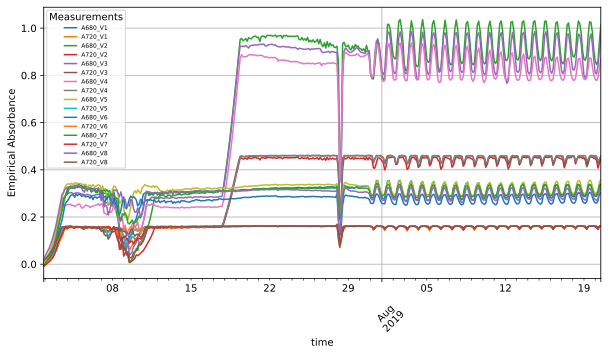

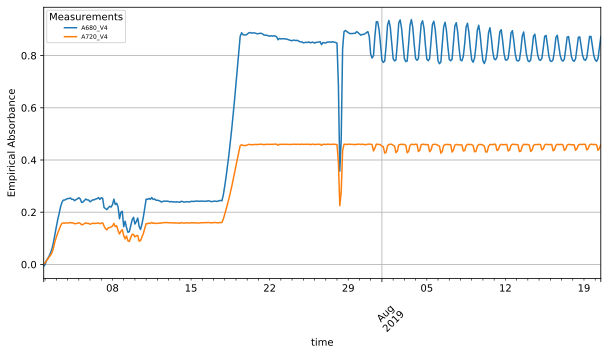

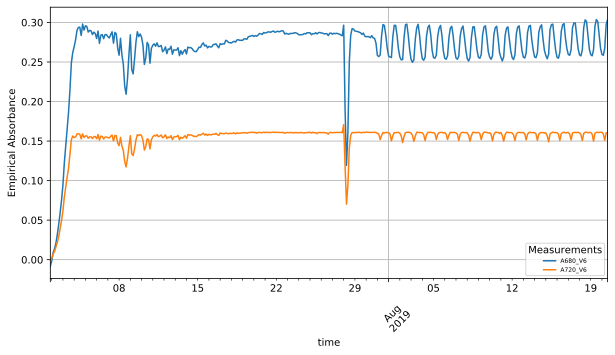

In [33]:
# PBR4 Raw Vis
raw_data_visualizer(return_resampled_df(dfs[3], rtime='3 hour', clean=True)) 

for x in ['V4', 'V6', ]:
    raw_data_visualizer(return_resampled_df(dfs[3][[i for i in dfs[3].columns if x in i]], rtime='3 hour', clean=True)) 


In [34]:
d3unc = pbr_modeled_560[3]
d3cor = pbr_modeled_560c[3]
d3cnt = pbr_modeled_560cor4counts[3]

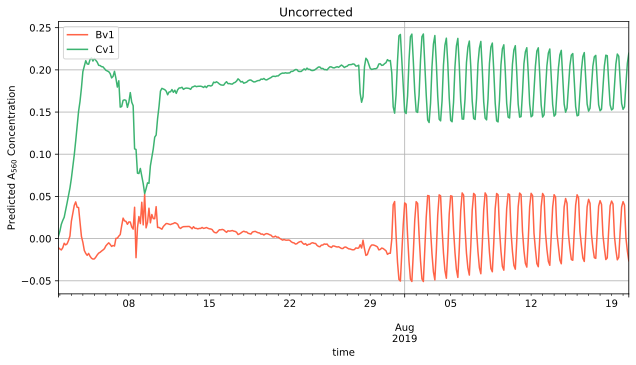

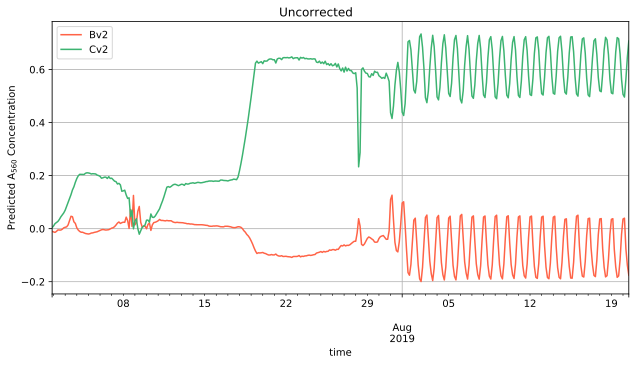

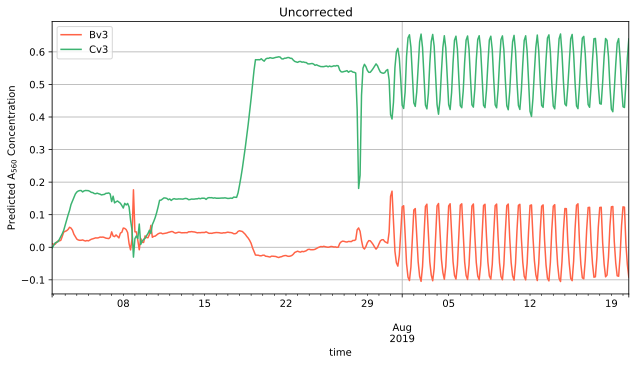

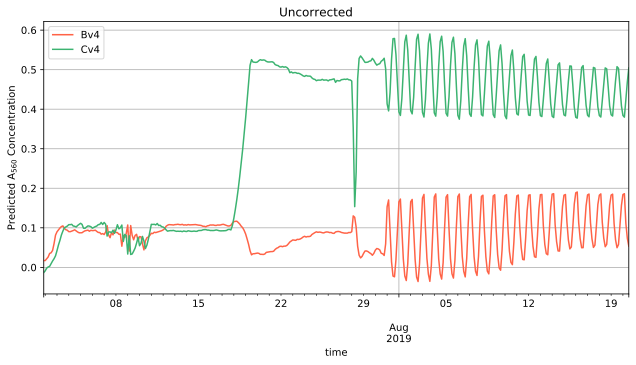

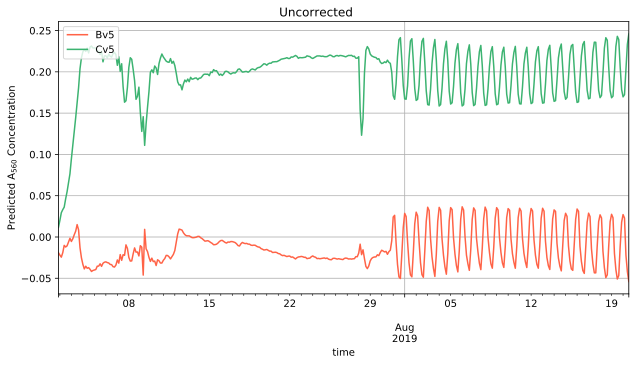

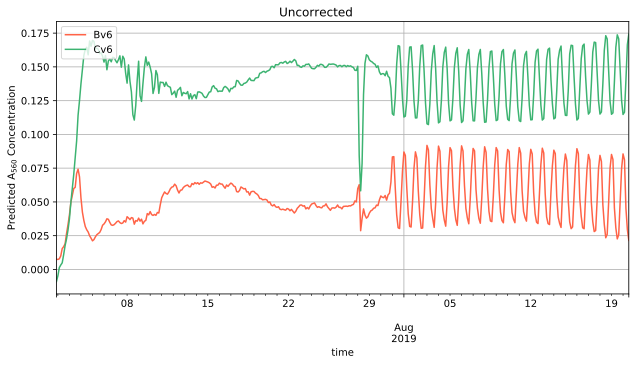

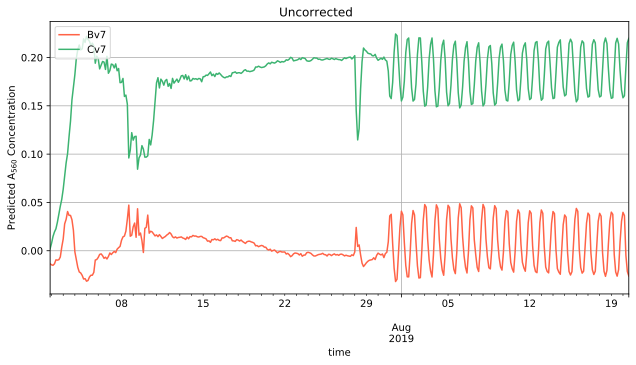

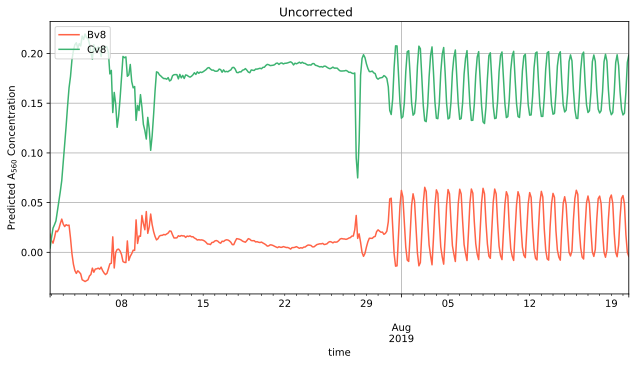

In [35]:
visualize_pbr_predictions(return_resampled_df(d3unc, rtime='3 hour', clean=True), corr='Uncorrected')

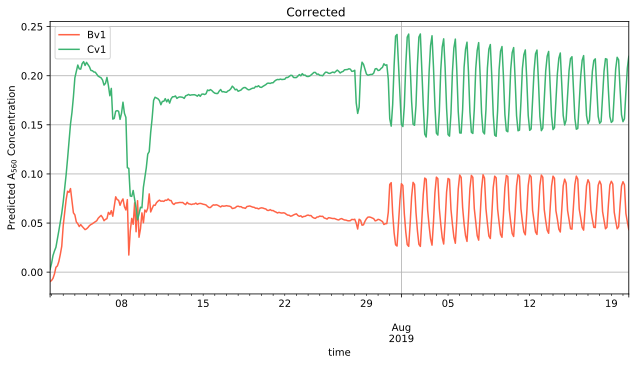

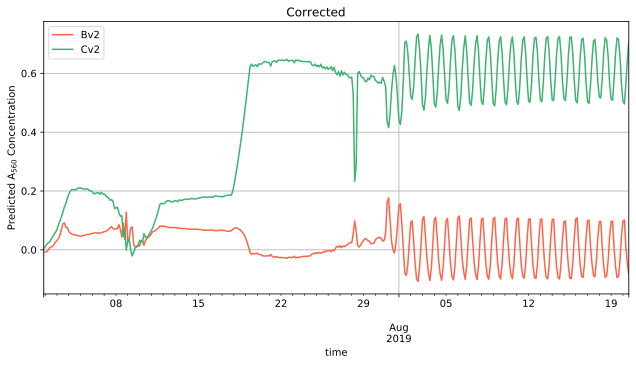

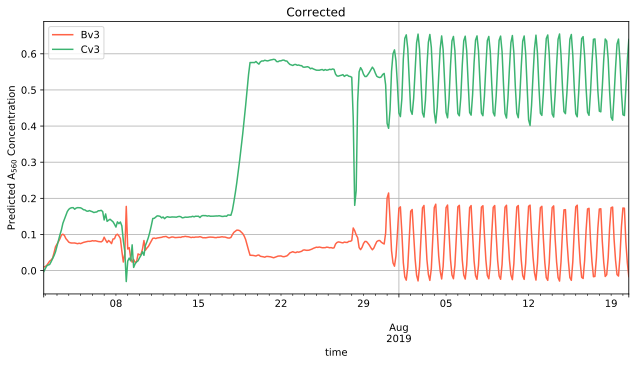

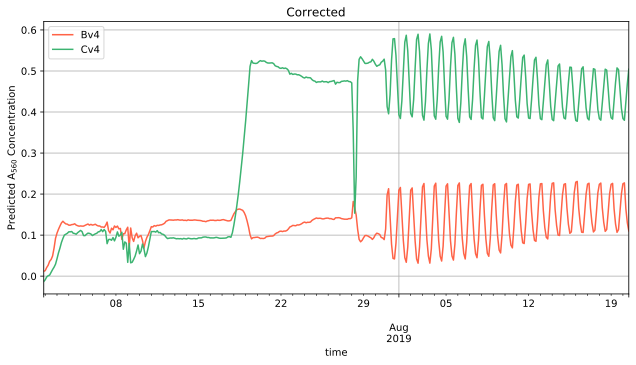

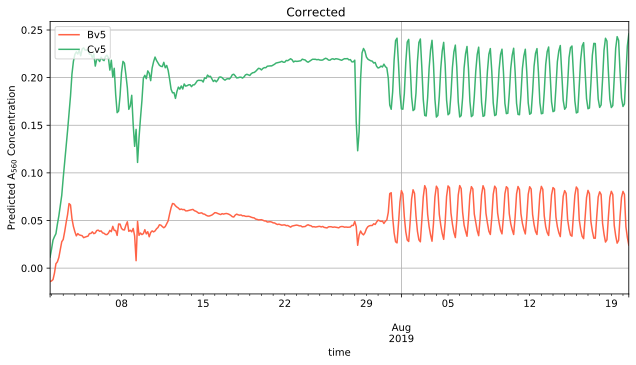

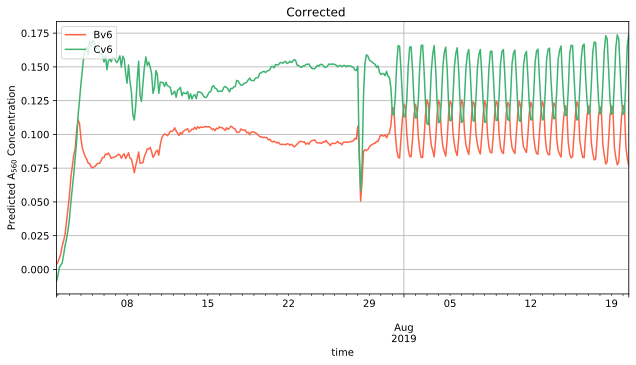

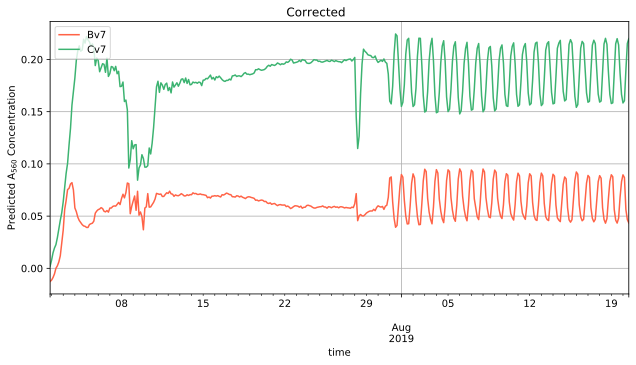

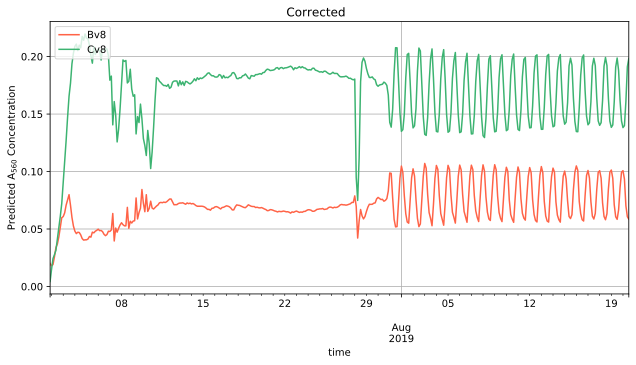

In [36]:
visualize_pbr_predictions(return_resampled_df(d3cor, rtime='3 hour', clean=True), corr='Corrected')

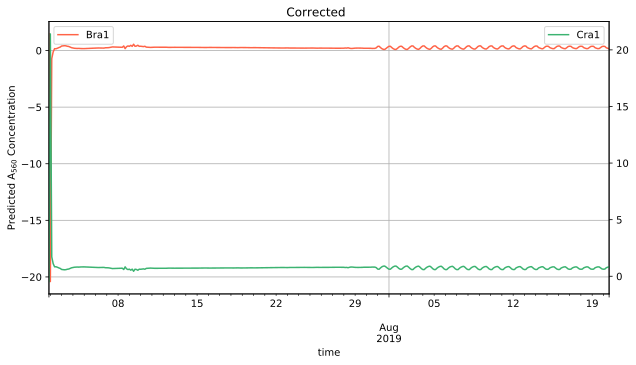

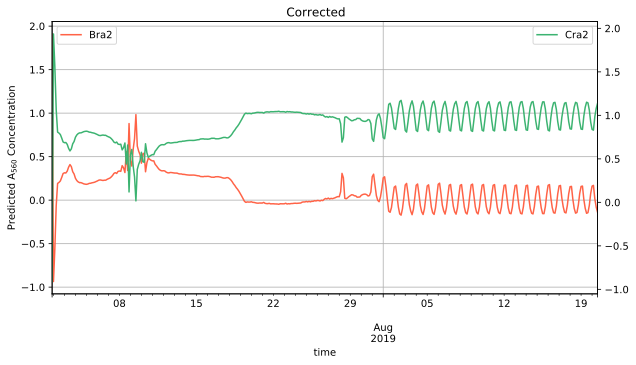

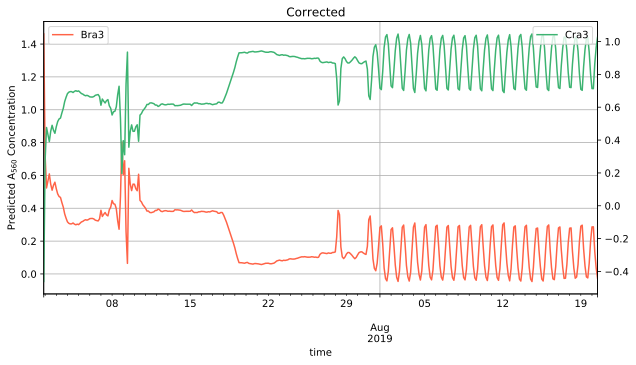

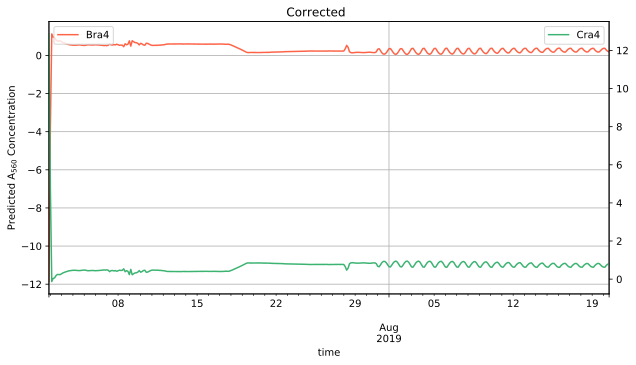

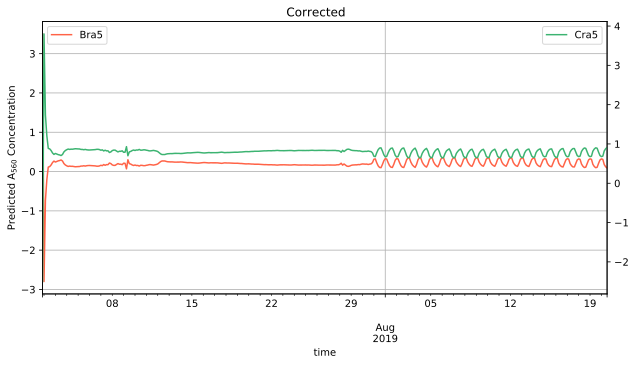

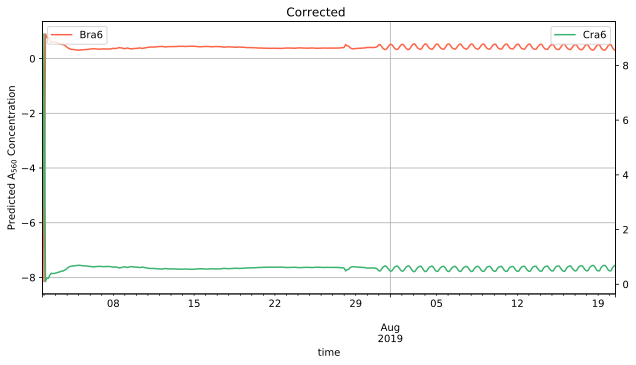

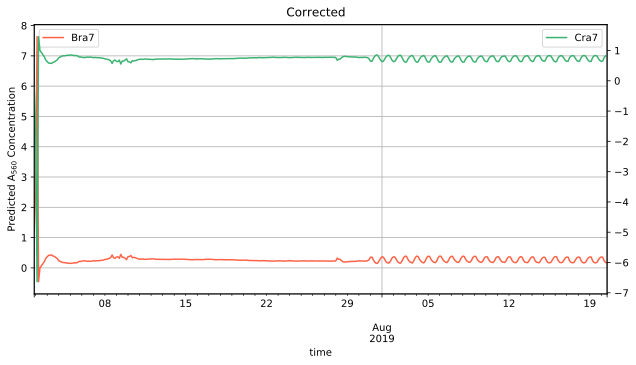

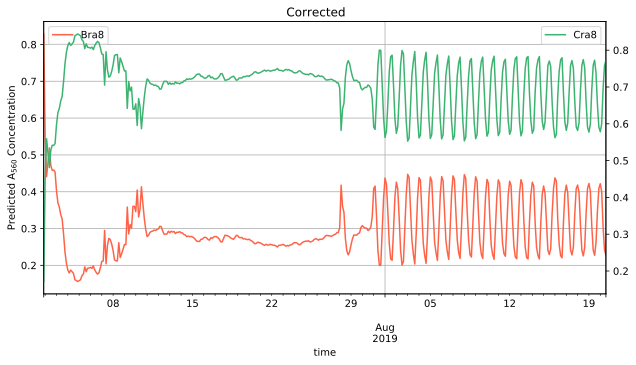

In [37]:
visualize_pbr_predictions(return_resampled_df(d3cor, rtime='3 hour', clean=True),sig_ra=True, corr='Corrected')

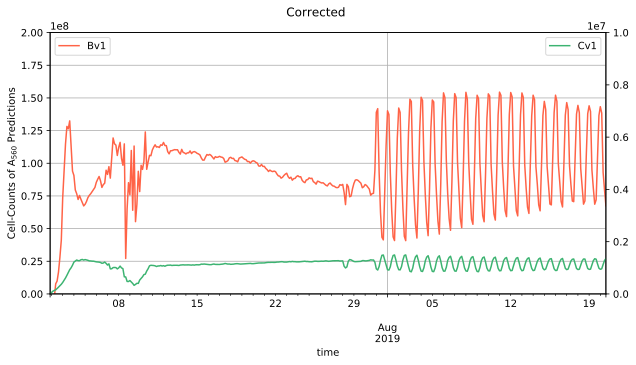

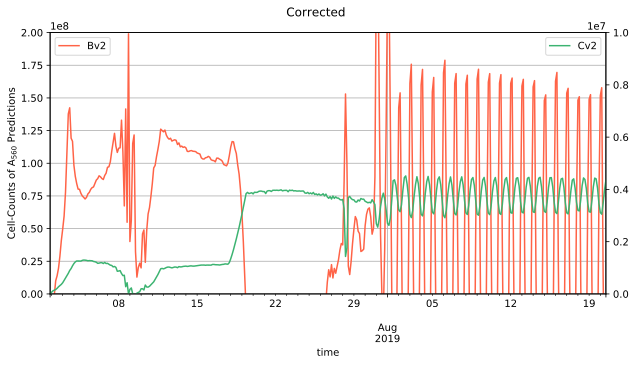

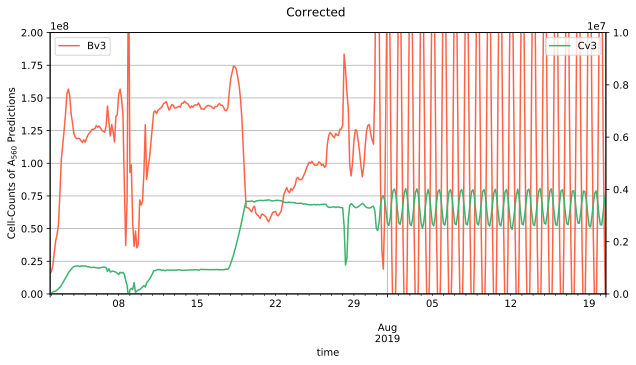

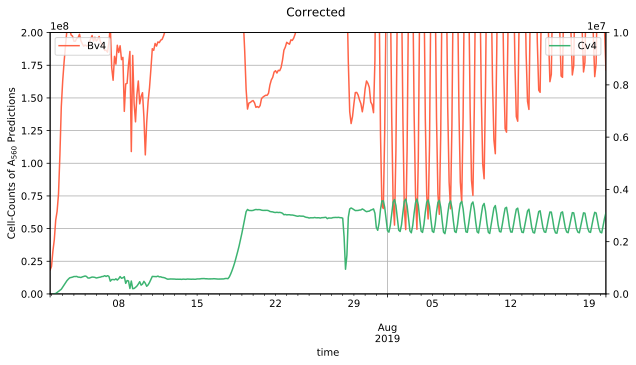

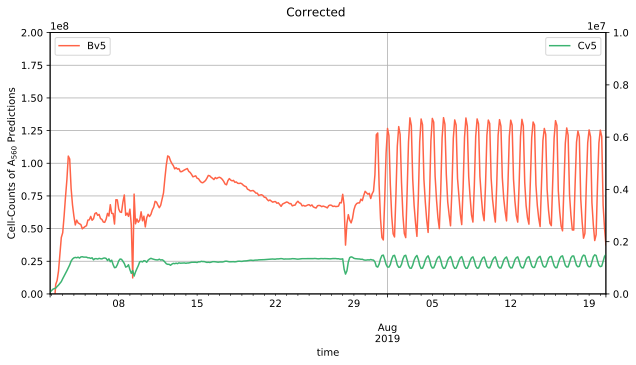

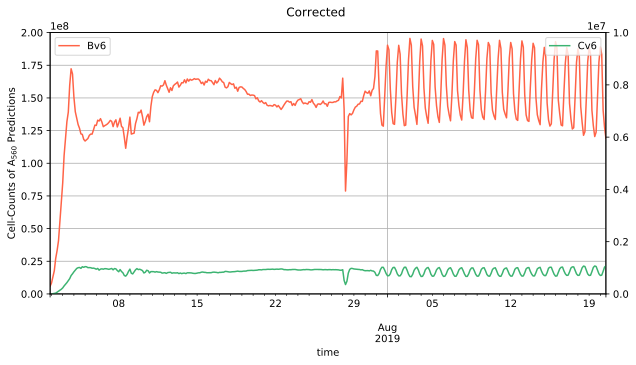

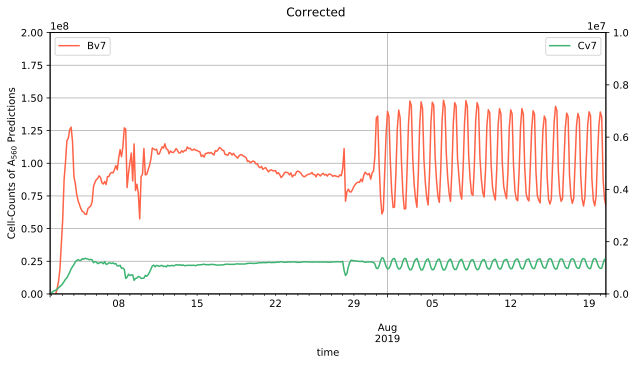

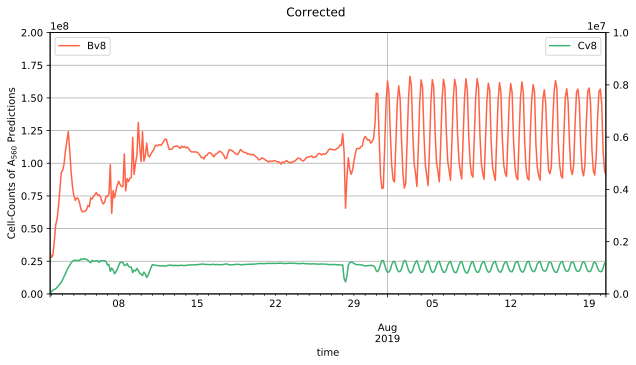

In [38]:
# cell counts
visualize_pbr_CC_predictions(return_resampled_df(d3cnt, rtime='3 hour', clean=True))

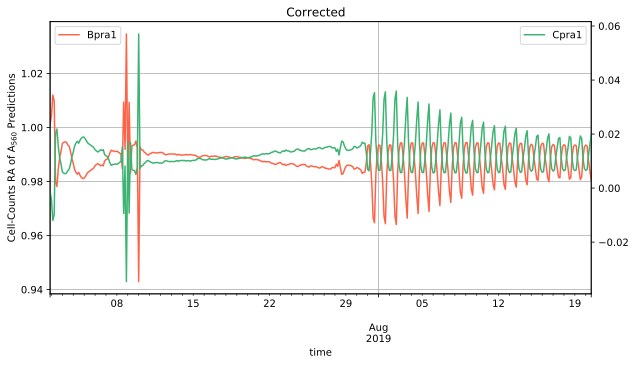

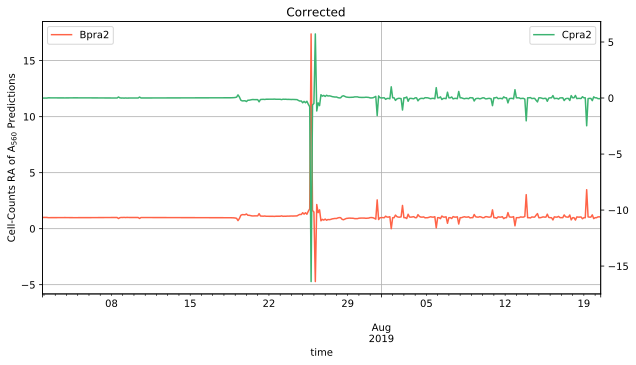

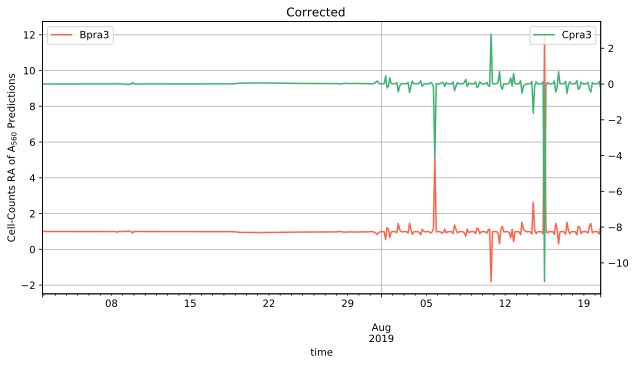

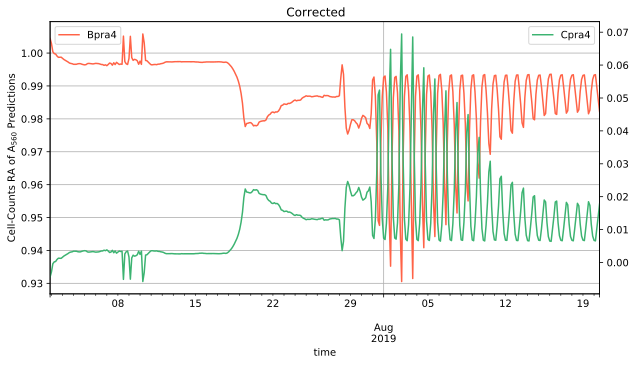

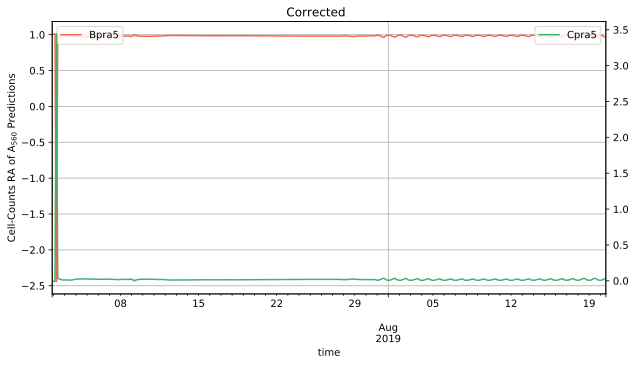

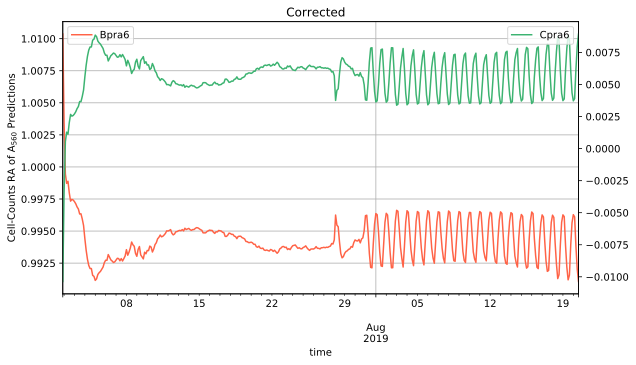

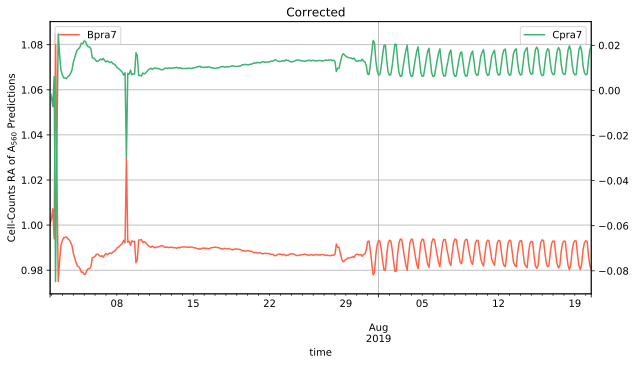

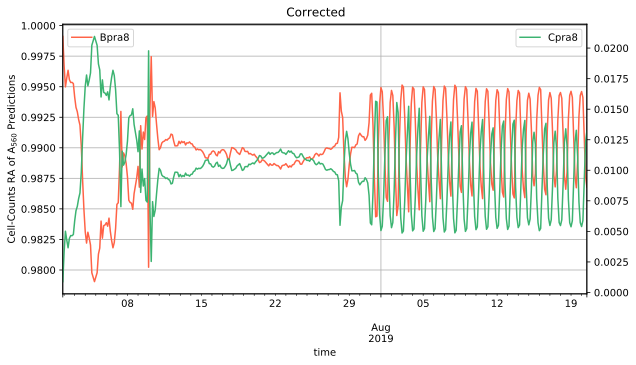

In [39]:
# relativa abundances of predicted cell counts
visualize_pbr_CC_predictions(return_resampled_df(d3cnt, rtime='3 hour', clean=True), ra=True)

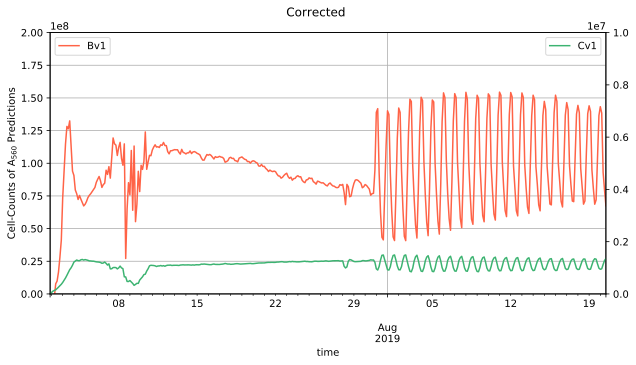

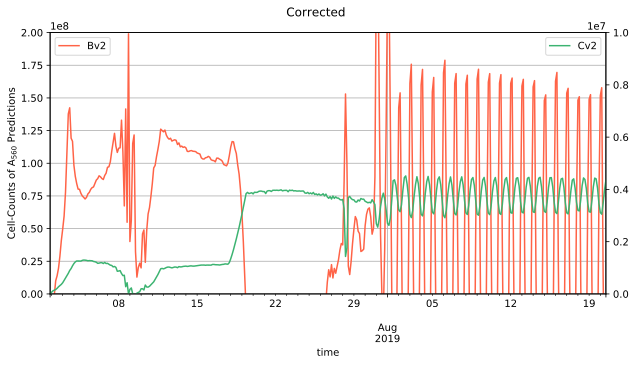

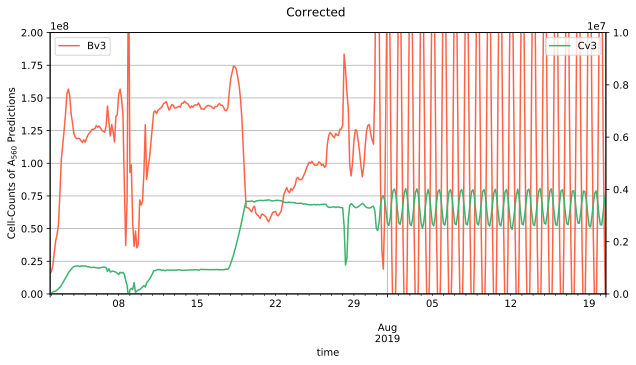

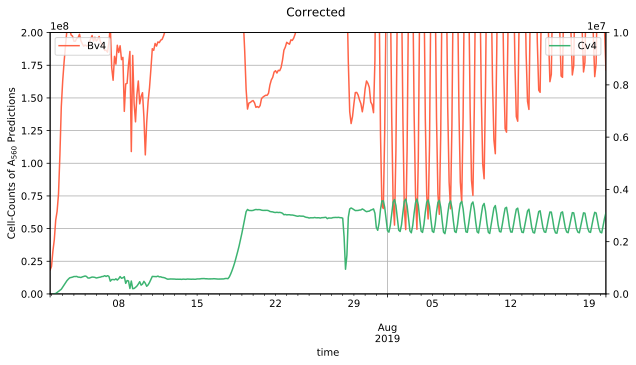

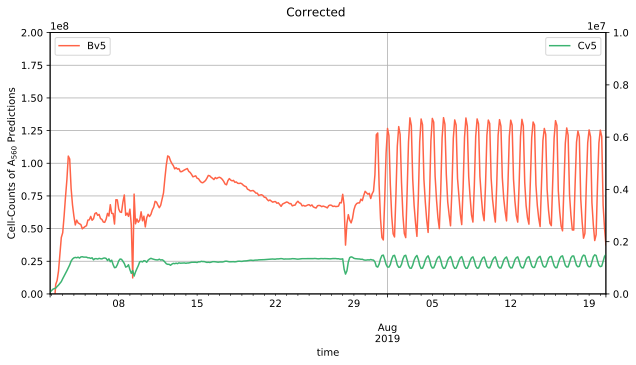

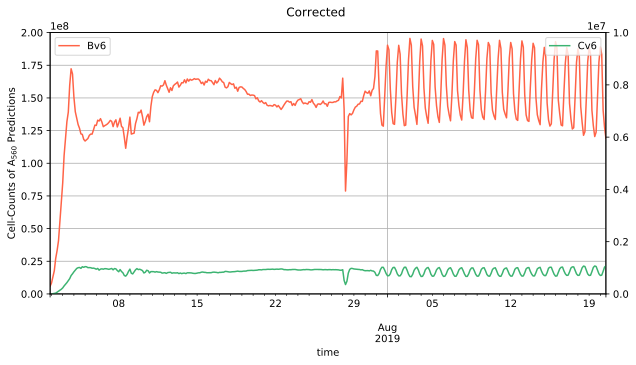

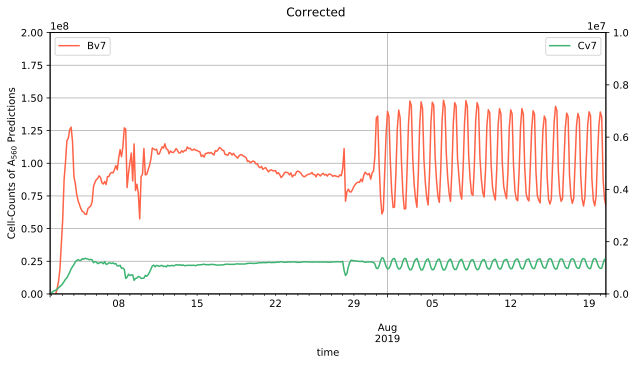

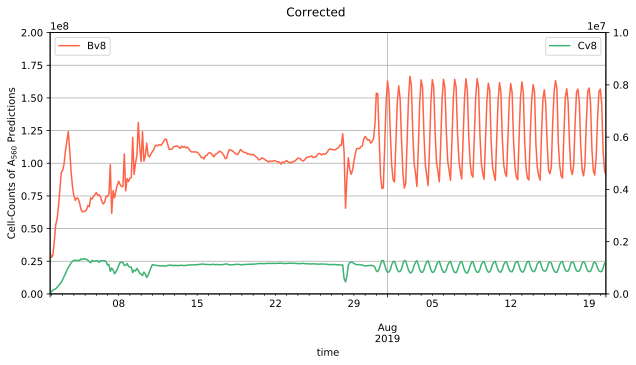

In [40]:
visualize_pbr_CC_predictions(return_resampled_df(d3cnt, rtime='3 hour', clean=True))

# Extract Dates for TecPBR Compare

In [41]:
### This is done to extract the relevant information for comparing PBR-Tecan measured...

In [42]:
exp2_dates = ['2019-04-17 21:00:00', '2019-04-18 17:30:00',
               '2019-04-19 12:30:00', '2019-04-20 16:45:00',
               '2019-04-21 20:00:00', '2019-04-22 14:00:00',
               '2019-04-23 15:30:00', '2019-04-24 17:30:00',
               '2019-04-25 16:30:00', '2019-04-26 17:45:00',
               '2019-04-27 18:15:00', '2019-04-28 18:45:00',
               '2019-04-29 17:45:00']

exp3_dates = ['2019-05-11 19:00:00', '2019-05-12 19:30:00',
               '2019-05-13 19:45:00', '2019-05-14 20:30:00',
               '2019-05-15 17:15:00', '2019-05-16 16:45:00',
               '2019-05-17 14:30:00', '2019-05-20 15:15:00',
               '2019-05-21 14:45:00', '2019-05-22 15:15:00',
               '2019-05-23 15:00:00', '2019-05-24 16:45:00']

# # There are exp2 and exp3 data predictions which is required to compare against the
# # tecan measured predictions.... here we extract the required datetime mesures
# e2 = pbr_modeled_560[1]
# e3 = pbr_modeled_560[2]

# to_concat = []
# for i in exp2_dates:
    
#     to_concat.append(extract_pbr_timeseries_row(e2, i))

# e2 = pd.concat(to_concat)
# e2

# to_concat = []
# for i in exp3_dates:
    
#     to_concat.append(extract_pbr_timeseries_row(e3, i))

# e3 = pd.concat(to_concat)
# e3

# # path to save
# save_path = '/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/pbr/pbr_exp_preprocessed'
# e2[[i for i in e2.columns if 'v' in i]].to_csv(pjoin(save_path, 'pbr2_at_samplingtime_tecan_compare.csv'))
# e3[[i for i in e3.columns if 'v' in i]].to_csv(pjoin(save_path, 'pbr3_at_samplingtime_tecan_compare.csv'))

# Extract Dates for TecPBR Compare END

# Compare SLR vs. MLR Regressions (Predictions) OBSOLOTE

    What I note here is that for SLR & MLR predictions for [B] tend to be very similar. In fact the difference in predictions are very minute ranging in mean between (0.003-0.005). On the other hand the differences of the predictions for [C] are a little bit more marked, ranging between (0.007-0.013)

In [43]:
# for df in pbr_modeled_560:
#     difs = sorted([i for i in df if 'dif' in i])
#     df[difs].describe()
#     'compare mlr and slr'
#     #mlr_slr_compare(df)
#     #show_difs(df)
#     # break

In [44]:
#visualize_pbr_predictions(pbr_modeled_560[1], x_range='all', tube_list='all', ratio_only=True)

# Microplate to Multi-Cultivator Model Conversion (OLD)
 
    This conversion was created before knowledge of the Tecan automatically correcting its values
    so that they conform to the readings that would have been taken using a standart 1cm cuvette

    # This was done before we knew that the Tecan normalizes the measurements
    # so that they match kX = E * 1cm
    
    # Extinction Coefficients as calculated by hand
    
    Absorbance = E*l*[S] = ext_coef * path_len * concentration
    
    The Fitted Coefficients below were obtained by fitting
    a line to the absorbace data generated to create the
    models, for example at a give wavelength we measure the
    signal for both chlamy and bacteria:
        kC = ext_coef * path_len
        kB = ext_coef * path_len
    
    The extinction coefficient of a given species in a
    particular medium is a constant value at the wavelength
    used. This means we can pull the extinction coef from
    one system and use it in another if we know the path 
    lengths for both systems...Thus to obtain 'ext_coef' we 
    divide by the actual path length of one vessel, in this
    case the microplate well--here the measurements are taken 
    from top to bottom in each well, thus 'path_len' is
    dependant on the volume of sample in each well... in the
    assay we filled each cylindrical well with 250uL of sample:
    
    # However, the pathlength should corrected by the Tecan
    # and thus when we perform the regression the constant kX
    # should be equivalent to E (if the media is primarily water)
    #### kX = E (1/M*cm) #### no further correction should be
    # necessary
    
    
    E = x.xx (1/M*cm)
    
        V = pi * r^2 * h
        
        h = path_len
        r = d / 2
        d = well diameter = .695 cm
        
        path_len = V / (pi * (d/2)^2)
        path_len = 4*V / (pi * d^2)
        
        V = 250uL = .250 cm^3
        
        path_len = .65899 cm
        
        
    Fitted Coefficients
    # Chlamy:
        k680 = 2.519103 (1/M*cm)
        k680*= 2.325735
        k720 = 1.132209
        
    # Bacter:
        k680 = 1.237138
        k680*= 1.208781
        k720 = 1.167253
        
    If we divide these fitted constants by the path length of
    the microplates we will obtain the extinction coefficient 
    for chlamy and bacter at those respective wavelenths.
    
    After we obtain the extinction coefficient we multiply
    times the path length of the multicultivator which is
    2.7 cm 


# Load, Convert & Apply Single Species Models
    
    The following models have been generated using Tecan Infinity 200Pro measured 680nm and 720nm wavelengths as regressands and all other wavelengths as the regressor. Here we apply A560 as the regresssor because it appears to be the least colinear wavelength to either of the regressands and thus should help avoid the multicoliniearity problem. The absorbance values are standardized by the Tecan measuring instrument to correspond to a pathlength of 1cm, thus each coefficient has units of (1/cm). 
    
    Often when these types of regressions are performed they're performed on compounds who have been prepared using molarity (i.e. a type density) for concentration . Thus the coefficients are determined to have units of molarity kX (1/M) which cancels out the units of the regressor (M) and yeilds a unitless absorbance value. However we're using another wavelength as 'concentration': This means that when we determine our coefficients they are already unitless. If we need to calculate E    (extinction coefficient) we would divide by a pathlength 'l' and thus E would have units of 1/cm).
    
    E = k0 / l 
    
    A680 = k0*[A560] = E*l*[A560] <---- this holds true when you're looking at Tecan data. Given that the Tecan
    measurements have been normalized so that l=1.0cm and the tubes of the PBR measure 2.7cm we need to perfrom
    the following conversions in order to apply the models to the PBR data.
    
    E = kC / l, but because l = 1.0,
    E = kC' where kC' has units of  (1/cm)
    